# Inits

In [1]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

# Reading and formatting data

## Read in data
Gilbert provides two datasets, one containing all the info about the sgRNAs, other one containing all of what he generated about the annotated genes. Both are imported, and distances between 5' of the PAM and both ends of the primary and secondary TSS sites of the gene are calculated, for usage in the model.

In [2]:
# dataframe containing sequences, targeted genes, and scores
df = pd.read_excel("data/elife-19760-supp1-v2.xlsx")
df = df.rename(columns = {"sgRNA sequence": "sequence",
                          "gene symbol": "gene",
                          "distance_to_CAGE": "distance",
                          "sgRNA length (including PAM)": "length",
                          "PAM genomic coordinate [hg19]" : "PAM_coord",
                          "CRISPRi activity score [Horlbeck et al., eLife 2016]": "score"})

# dataframe containing annotated gene locations
gene_df = pd.read_excel("data/elife-19760-supp2-v2.xlsx")
gene_df = gene_df.rename(columns = {"Primary TSS, 5'": "prim_TSS_5p",
                                    "Primary TSS, 3'": "prim_TSS_3p",
                                    "Secondary TSS, 5'": "sec_TSS_5p",
                                    "Secondary TSS, 3'": "sec_TSS_3p"})

# merging the two, determining distance between PAM and TSS
df = pd.merge(df, gene_df, on = ("gene", "chromosome"), how = "left")
df["prim_TSS_dist5p"] = df["PAM_coord"] - df["prim_TSS_5p"]
df["prim_TSS_dist3p"] = df["PAM_coord"] - df["prim_TSS_3p"]
df["sec_TSS_dist5p"] = df["PAM_coord"] - df["sec_TSS_5p"]
df["sec_TSS_dist3p"] = df["PAM_coord"] - df["sec_TSS_3p"]
df = df[(df["prim_TSS_dist5p"] > -3000) & (df["prim_TSS_dist5p"] < 3000)]

## Linearizing TSS distance
Gilbert's paper mentions linearizing primary and secondary distance to TSS using an SVR, and then using the outputs of the SVM as variables for the distance from TSS. Not quite sure why this works, or why they need to be linearized.

### Formatting and binning data
Binning is primarily for visualization (data can be quite crowded), but also can be used for fitting to SVR

C:\Users\Jackson\AppData\Local\Temp\ipykernel_33168\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()
C:\Users\Jackson\AppData\Local\Temp\ipykernel_33168\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()


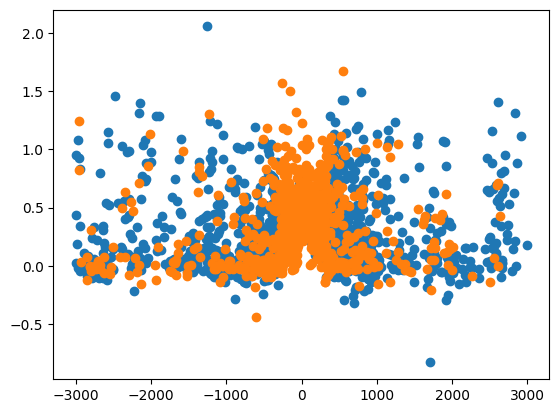

In [84]:
df = df.dropna()
X = df.dropna(subset = "prim_TSS_dist5p").loc[:, ["prim_TSS_dist5p"]]
y = df.dropna(subset = "prim_TSS_dist5p").loc[:, "score"]

# splitting training/test sets
perc_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)

def bin_and_average(df, bins):    
    df["X_bin"] = pd.cut(df["prim_TSS_dist5p"], bins = bins)
    
    bin_means = df.groupby("X_bin")["score"].mean().reset_index()
    bin_means["center"] = bin_means["X_bin"].apply(lambda row: row.left + (np.abs(row.left - row.right) / 2))
    
    return bin_means.dropna()

concat_df = pd.concat([X_train, y_train], axis = 1)
num_bins = 50000
binned_df = bin_and_average(concat_df, int((1 - perc_test) * num_bins))

binned_test_df = bin_and_average(pd.concat([X_test, y_test], axis = 1), int(perc_test * num_bins))

plt.scatter(binned_df["center"], binned_df["score"])
plt.scatter(binned_test_df["center"], binned_test_df["score"])

### Fitting model to SVR
Two statements are given - one is to fit to binned data, other is to fit to actual data. GridSearchCV is commented out because it takes a long time and seems to overfit to the existing data, but should probably be messed around with more in the future.

In [85]:
# fitting SVR
svr = svm.SVR(kernel = "rbf")
parameters = {'C': np.logspace(-2, 2, num = 5),
              "gamma": np.logspace(-8, 0, num = 12)}
grid_svr = GridSearchCV(svr, parameters, n_jobs = -1, scoring = "neg_mean_squared_error")

# fitting to binned data
grid_svr.fit(binned_df["center"].to_numpy().reshape(-1, 1), binned_df["score"].to_numpy().reshape(-1, 1))
print(f"R^2: {grid_svr.score(binned_test_df['center'].to_numpy().reshape(-1, 1), binned_test_df['score'].to_numpy().reshape(-1, 1))}")

# fitting directly to data
# grid_svr.fit(X_train, y_train)
# print(f"R^2: {grid_svr.score(X_test, y_test)}")

R^2: -0.07866193460219982


c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
grid_svr.best_params_

{'C': 1.0, 'gamma': 1.519911082952933e-06}

### Plotting fit
Plotted with binned values and actual values

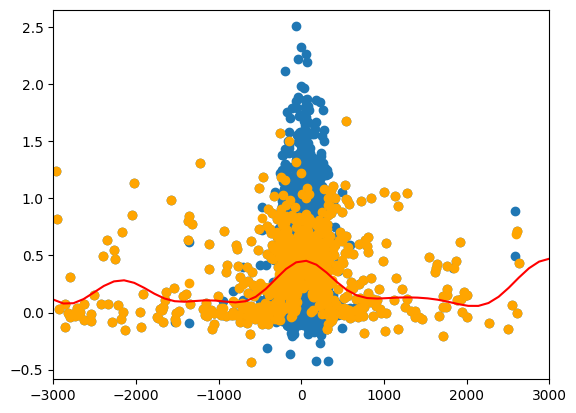

In [87]:
plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(plot_X)

plt.scatter(X_test, y_test)
plt.scatter(binned_test_df["center"], binned_test_df["score"], color = "orange")
plt.plot(plot_X, y_pred, color = "red")
plt.xlim(-3000, 3000)
plt.show()

### Adding linearized distance
Adding linearized values (obtained from SVM fit) for all four distance vectors. Plots for each for sanity.

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


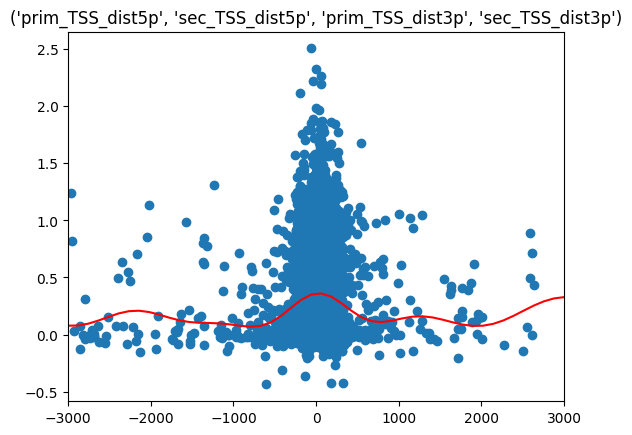

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


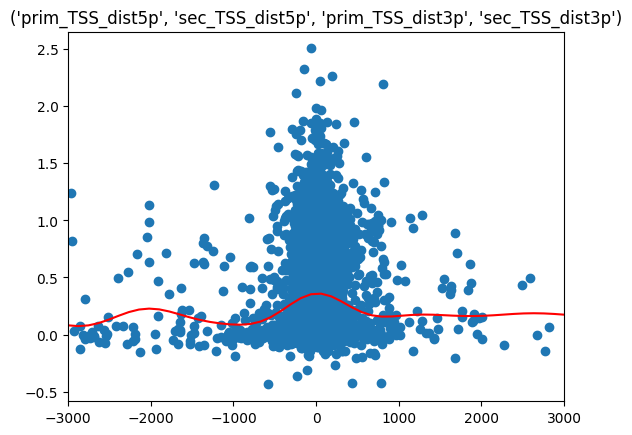

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


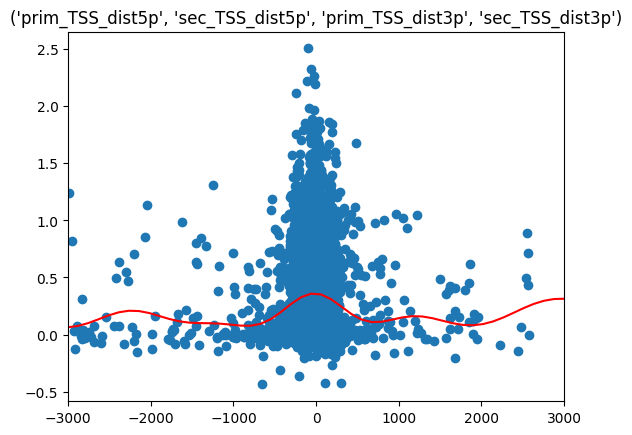

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


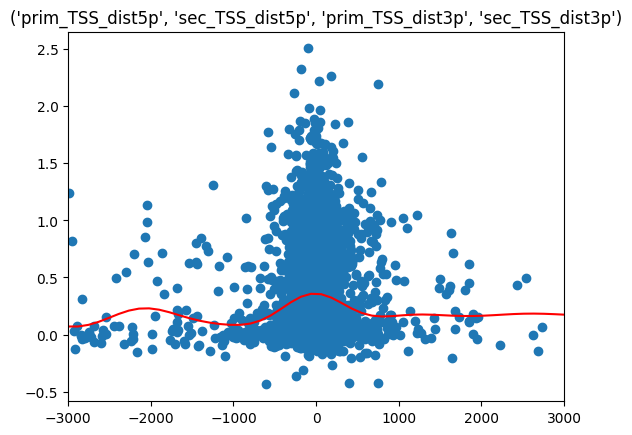

In [46]:
vars = ("prim_TSS_dist5p", "sec_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist3p")

for var in vars:
    # setting up X and y for variable
    X = df.dropna(subset = var).loc[:, [var]]
    y = df.dropna(subset = var).loc[:, "score"]
    
    # splitting training and testing sets based on value defined earlier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)
    best_svr.fit(X_train, y_train)
    
    # update original dataframe with normalized values
    df[("norm_" + var)] = best_svr.predict(df[var].to_numpy().reshape(-1, 1))
    
    plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
    y_pred = best_svr.predict(plot_X)

    plt.scatter(X_test, y_test)
    plt.plot(plot_X, y_pred, color = "red")
    plt.xlim(-3000, 3000)
    plt.title(var)
    plt.show()

## Adding additional columns for fitting
Adding fraction of each base, GC content

In [47]:
for base in ("A", "C", "T", "G"):
    df[("frac_" + base)] = df.apply(lambda row: row["sequence"].count(base) / row["length"], axis = 1)
    
df["GC_content"] = df["frac_C"] + df["frac_G"]

## Running off-target analysis for each sgRNA
Commented out for now because this will probably take a day to run

In [19]:
# # normalize all sgRNAs to have the same length as th
# # e max length sgRNA (by adding Ns in front)
# max_len = df["sequence"].apply(len).max()

# def normalize_str_len(str, max_len):
#     while len(str) < max_len:
#         str = "N" + str
#     return(str)

# df["sequence"] = df["sequence"].apply(normalize_str_len, args = (max_len,))

# # preparing input strings for cas-offinder
# pam = "NGG"
# full_pam = ("N" * max_len) + pam

# co_input = f"../genomes/human_hg19\n{full_pam} 2 1"
# for i, seq in enumerate(df["sequence"], start = 1):
#     co_input = co_input + f"\n{seq}NNN 3 Seq{i}"

# # write input string to input.txt for cas-offinder
# with open("input.txt", "w") as file:
#     file.write(co_input)

# # running subprocess for cas-offinder (WARNING: MAY TAKE A VERY LONG TIME TO RUN)
# subprocess.run(f".\cas-offinder input.txt G output.txt")

# co_output = pd.read_csv("output.txt", sep = "\t", comment = "#", header = None)
# co_output.columns = ["WT", "chromosome", "posn", "OT", "dir", "mismatches"]

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working. So I tried RF regression and got an ROC AUC better than his with fewer features, which tells me I'm probably doing something wrong. Please double check all of this and read through it with like, 15 grains of salt.

## Organizing, scaling data

In [159]:
X = df.loc[:, ["norm_prim_TSS_dist5p",
               "norm_prim_TSS_dist3p",
               "norm_sec_TSS_dist5p",
               "norm_sec_TSS_dist3p",
               "frac_A",
               "frac_C",
               "frac_G",
               "frac_T",
               "GC_content",
               "length"]]
y = df.loc[:, "score"]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for var in vars:
    X[("norm_" + var)] = scaler.fit_transform(X[[("norm_" + var)]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fitting model

In [136]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators = 100)

params = {
    "n_estimators": [300]
}
grid_rf_red = GridSearchCV(rf_reg, params, scoring = "neg_mean_squared_error")
grid_rf_red.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [300]},
             scoring='neg_mean_squared_error')

## Comparing model fit with test set

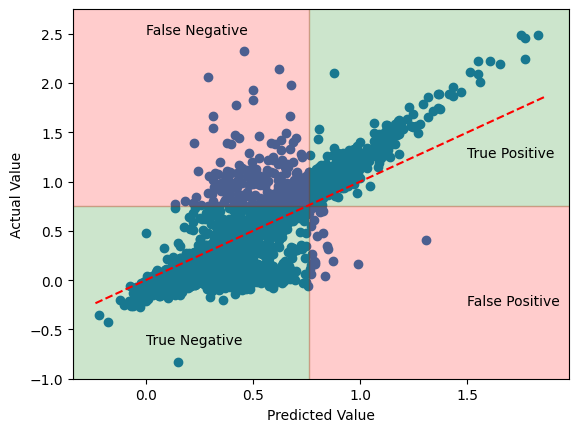

In [194]:
best_rf_reg = grid_rf_red.best_estimator_
# df["pred_score"] = best_rf_reg.predict(X)
y_pred = best_rf_reg.predict(X_test)

x = np.linspace(np.min(df["pred_score"]), np.max(df["pred_score"]), 100)
plt.scatter(y_pred, y_test)
plt.plot(x, x, color='red', linestyle='--', label='Identity Line (y=x)')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, 0.75, color = "green", alpha = 0.2, xmax = 0.475)
plt.axhspan(0.75, 5, color = "green", alpha = 0.2, xmin = 0.475)
plt.axhspan(-5, 0.75, color = "red", alpha = 0.2, xmin = 0.475)
plt.axhspan(0.75, 5, color = "red", alpha = 0.2, xmax = 0.475)
plt.text(1.5, 1.25, "True Positive")
plt.text(0, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(0, 2.5, "False Negative")
plt.ylim([-1, 2.75])
plt.show()

## ROC curve (and other metrics)

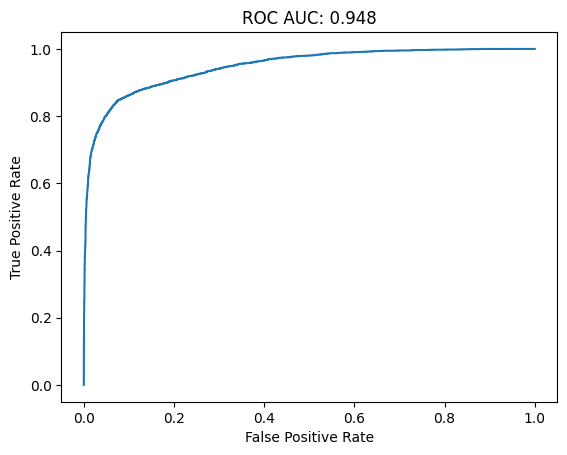

In [196]:
from sklearn.metrics import roc_curve, auc

df["actual_pos"] = df["score"] >= 0.75

fpr, tpr, thresholds = roc_curve(df["actual_pos"], df["pred_score"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()